# Setup

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import copy
import functools
import itertools
import logging
import re
import time
import yaml
from collections import Counter

import humanize
from pymicro.file import file_utils
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import scipy as sp
from numpy import ndarray
from matplotlib import pyplot as plt, patches, cm
from sklearn import metrics as met
from progressbar import progressbar as pbar
from tensorflow.keras import layers
from sklearn import metrics, preprocessing
from sklearn import model_selection
import skimage
from skimage import measure, io
import pandas as pd
import seaborn as sns
import pandas as pd

import tomo2seg.data as tomo2seg_data
from tomo2seg.data import ModelPaths, Volume, EstimationVolume, SetPartition
from tomo2seg.volume_img_segm import VolumeImgSegmSequence
from tomo2seg import viz
from tomo2seg.logger import logger

In [3]:
from tomo2seg.data import VOLUME_PRECIPITATES_V1 as VOL_NAME_VERSION
logger.debug(f"{VOL_NAME_VERSION=}")

In [4]:
logger.setLevel(logging.DEBUG)

In [5]:
random_state = 42
random_state = np.random.RandomState(random_state)

# Load from the disk

In [7]:
# Metadata/paths objects

## Volume
volume = Volume.with_check(
    volume_name := VOL_NAME_VERSION[0], 
    volume_version := VOL_NAME_VERSION[1]
)
logger.info(f"{volume=}")

hst_read = lambda x: functools.partial(
    # from pymicro
    file_utils.HST_read,
    # pre-loaded kwargs
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=volume.metadata.dtype,
    dims=volume.metadata.dimensions,
    verbose=True,
)(str(x))  # it doesn't accept paths...

[2020-11-12::17:18:02.658] tomo2seg :: DEBUG :: {data.py:with_check:214}
vol=Volume(name='PA66GF30', version='v1', _metadata=None)

[2020-11-12::17:18:02.663] tomo2seg :: ERROR :: {data.py:with_check:232}
Missing file: /home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.labels.raw

[2020-11-12::17:18:02.665] tomo2seg :: WARNING :: {data.py:with_check:236}
Missing file: /home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.weights.raw

[2020-11-12::17:18:02.666] tomo2seg :: DEBUG :: {data.py:metadata:171}
Loading metadata from `/home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.metadata.yml`.

[2020-11-12::17:18:02.681] tomo2seg :: INFO :: {<ipython-input-7-17f8e4c0fba7>:<module>:008}
volume=Volume(name='PA66GF30', version='v1', _metadata=Volume.Metadata(dimensions=[1300, 1040, 1900], dtype='uint8', labels=[0, 1, 2], labels_names={0: 'matrix', 1: 'fiber', 2: 'porosity'}, set_partitions={'train': {'x_range': [0, 1299], 'y_range': [0

# Porosity blobs

In [79]:
filename = volume.blobs3d_props_path(class_idx=2, labels_version="refined")  # 2 = porosity
logger.debug(f"{filename=}")

astype_map = {"area": int, "centroid-0": int, "centroid-1": int, "centroid-2": int}
rename_map = {"Unnamed: 0": "index", "centroid-0": "centroid-x", "centroid-1": "centroid-y", "centroid-2": "centroid-z"}
blobsdf = pd.read_csv(filename).astype(astype_map).rename(columns=rename_map).set_index("index")

logger.debug(f"{blobsdf.shape}")

blobsdf.loc[blobsdf.minor_axis_length == 0, "minor_axis_length"] = 1
blobsdf["aspect_ratio"] = blobsdf.major_axis_length / blobsdf.minor_axis_length

blacklist = np.zeros(blobsdf.shape[0]).astype(bool)

[2020-11-12::18:08:29.789] tomo2seg :: DEBUG :: {<ipython-input-79-a3a112c2557c>:<module>:002}
filename=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.labels-refined.blobs3d.props.class_idx=2.csv')

[2020-11-12::18:08:32.934] tomo2seg :: DEBUG :: {<ipython-input-79-a3a112c2557c>:<module>:008}
(263116, 94)



In [80]:
cols_no_moments_no_inertia = [c for c in blobsdf.columns if "moments_central" not in c and "inertia_tensor" not in c]
cols_no_moments = [c for c in blobsdf.columns if "moments_central" not in c]

In [81]:
pd.set_option("display.max_rows", 100)

In [83]:
blobsdf[cols_no_moments_no_inertia].head(3).T

index,0,1,2
label,2,2,2
area,3991,52,7
bbox-0,0,0,0
bbox-1,0,1,5
bbox-2,0,1175,1225
bbox-3,22,8,2
bbox-4,131,15,10
bbox-5,1900,1180,1226
bbox_area,5475800,560,10
extent,0.0007286,0.09283,0.7


In [85]:
blobsdf[cols_no_moments_no_inertia].describe().T

,count,mean,std,min,25%,50%,75%,max
label,263116.0,2.000000,0.000000,2.000000,2.000000,2.000000,2.000,2.000000e+00
area,263116.0,49.091758,184.860614,1.000000,5.000000,12.000000,37.000,2.833300e+04
bbox-0,263116.0,697.543563,363.849416,0.000000,417.000000,692.000000,1012.000,1.299000e+03
bbox-1,263116.0,515.557697,301.776332,0.000000,253.000000,512.000000,775.000,1.039000e+03
bbox-2,263116.0,919.245489,555.684397,0.000000,440.000000,883.000000,1402.000,1.899000e+03
bbox-3,263116.0,701.279493,363.817303,1.000000,420.000000,696.000000,1015.000,1.300000e+03
bbox-4,263116.0,523.383770,302.061704,1.000000,261.000000,518.000000,783.000,1.040000e+03
bbox-5,263116.0,922.072447,555.790254,1.000000,442.000000,885.000000,1405.000,1.900000e+03
bbox_area,263116.0,405.205012,11525.063332,1.000000,6.000000,24.000000,126.000,5.475800e+06
extent,263116.0,0.539877,0.290124,0.000729,0.295000,0.500000,0.750,1.000000e+00


# Cut off tiny blobs

In [87]:
blobs_area_threshold = 3

blacklist |= blobsdf.area <= blobs_area_threshold

In [88]:
blobsdf.loc[~blacklist, cols_no_moments_no_inertia].describe().T

,count,mean,std,min,25%,50%,75%,max
label,217593.0,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000e+00
area,217593.0,58.860818,201.918950,4.000000,7.000000,16.000000,47.000000,2.833300e+04
bbox-0,217593.0,699.331564,368.994517,0.000000,409.000000,696.000000,1022.000000,1.299000e+03
bbox-1,217593.0,516.259498,300.183024,0.000000,257.000000,513.000000,773.000000,1.039000e+03
bbox-2,217593.0,924.826061,558.598737,0.000000,441.000000,890.000000,1415.000000,1.899000e+03
bbox-3,217593.0,703.551622,368.945519,1.000000,413.000000,701.000000,1024.000000,1.300000e+03
bbox-4,217593.0,525.297165,300.494364,1.000000,266.000000,521.000000,783.000000,1.040000e+03
bbox-5,217593.0,928.031729,558.703284,1.000000,444.000000,893.000000,1419.000000,1.900000e+03
bbox_area,217593.0,489.393156,12671.828038,4.000000,12.000000,40.000000,180.000000,5.475800e+06
extent,217593.0,0.461517,0.247468,0.000729,0.265000,0.416700,0.666500,1.000000e+00


# area x aspect_ratio

CPU times: user 20.9 s, sys: 303 ms, total: 21.2 s
Wall time: 21.2 s


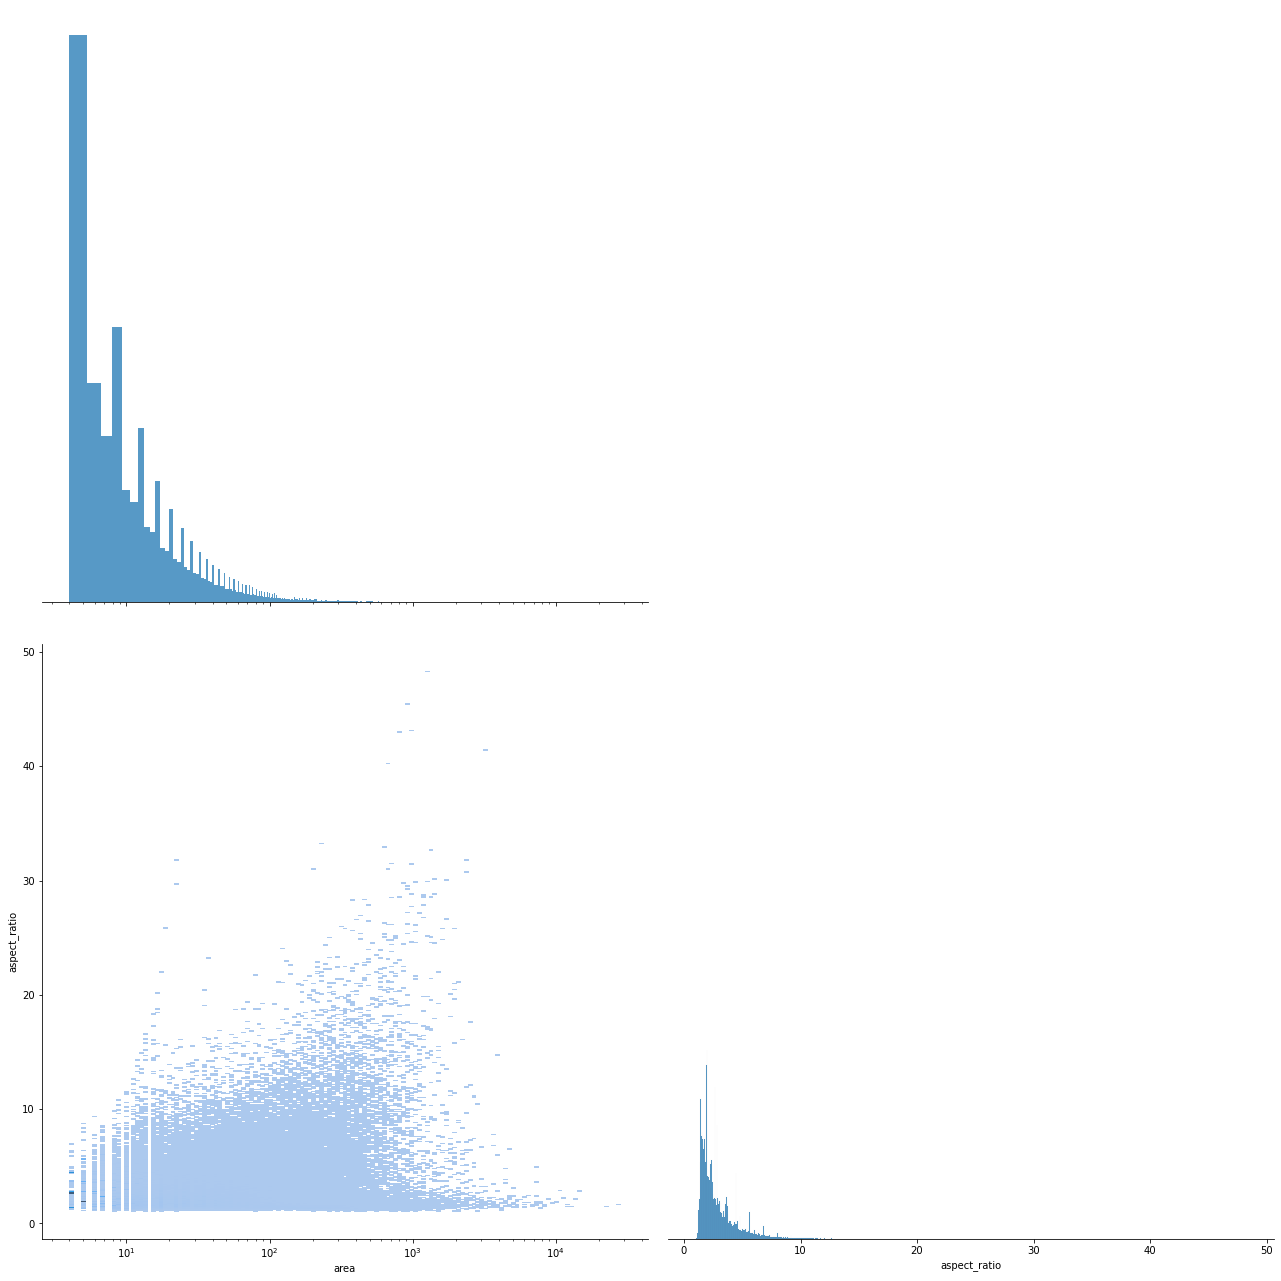

In [96]:
%%time
n = None
df = blobsdf[~blacklist]
df = df.iloc[:n] if n is not None else df

pairgrid = sns.pairplot(
    df,
    vars=["area", "aspect_ratio"],
    diag_kind="hist",
    diag_kws=dict(log_scale=False),
    kind="hist",
    plot_kws=dict(log_scale=(True, False), palette="inferno"),
    corner=True,
)
pairgrid.fig.set_size_inches(*(sz := 20, sz))

# `aspect_ratio` outliers

In [100]:
select = (~blacklist) & (blobsdf.aspect_ratio > 30)
print(select.sum())
blobsdf[select][cols_no_moments_no_inertia].T

18


index,1903,4664,24044,29147,161218,163890,199478,213772,220998,229211,234800,238594,245022,249520,252085,254862,258021,258920
label,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
area,2374,646,3182,686,837,652,205,702,237,1300,2319,974,23,992,913,1676,1323,1409
bbox-0,10,28,145,177,826,841,1022,1088,1123,1158,1183,1198,1224,1242,1253,1264,1277,1281
bbox-1,724,521,542,73,855,619,596,747,252,743,179,859,483,277,194,584,780,694
bbox-2,544,148,166,799,1826,1519,566,1718,705,1525,1830,1829,958,1792,853,764,626,1263
bbox-3,23,34,184,202,837,846,1025,1103,1133,1186,1193,1203,1226,1250,1265,1284,1286,1292
bbox-4,976,658,836,204,1024,761,680,871,340,958,388,1040,505,424,375,780,991,859
bbox-5,563,160,232,830,1858,1538,569,1729,713,1556,1837,1839,959,1807,867,786,641,1280
bbox_area,62244,9864,756756,101525,59488,13490,756,20460,7040,186620,14630,9050,44,17640,30408,86240,28485,30855
extent,0.03815,0.0655,0.004204,0.006756,0.01407,0.04834,0.2712,0.0343,0.03366,0.006966,0.1586,0.1076,0.523,0.05624,0.03003,0.01944,0.04645,0.04565
